Emotional Detection

In [10]:
import matplotlib.pyplot as plt
from glob import glob #glob is to create of all the files present in  a directory
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version",tf.__version__)

Tensorflow version 2.13.0


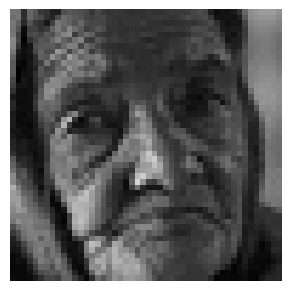

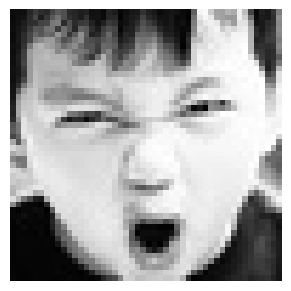

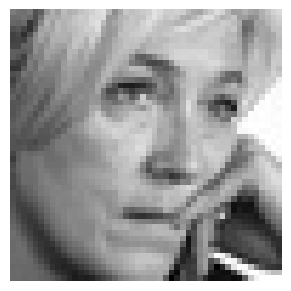

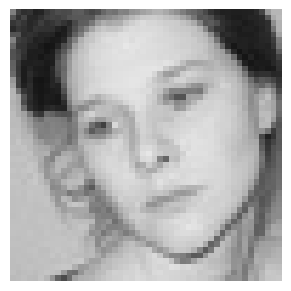

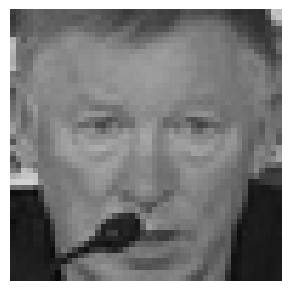

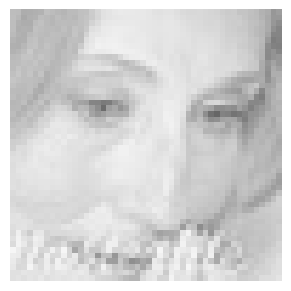

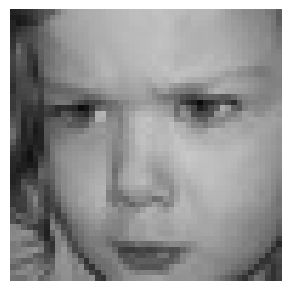

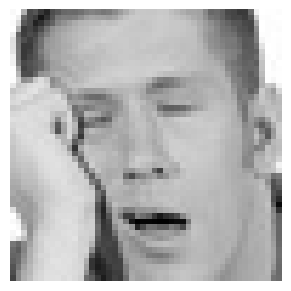

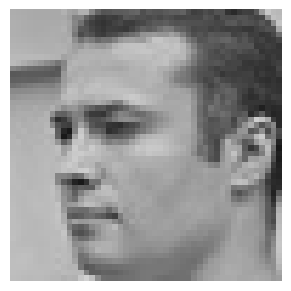

In [11]:
images= glob("/kaggle/input/fer2013/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis("off")

In [12]:
img_size=48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator= datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                  target_size=(img_size,img_size),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator= datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",
                                                  target_size=(img_size,img_size),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   shuffle=True)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
def convolutional(input_tensor,filters,kernel_size):
    x=Conv2D(filters= filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x= BatchNormalization()(x)
    x=Activation("relu")(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)
    return x

In [14]:
def Dense_f(input_tensor,modes):
    x=Dense(modes)(input_tensor)
    x= BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Dropout(0.25)(x)
    return x

In [27]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1= convolutional(inputs,64,(3,3))
    conv_2= convolutional(conv_1,128,(5,5))
    conv_3= convolutional(conv_2,256,(3,3))
    conv_4= convolutional(conv_3,512,(3,3))
    flatten=Flatten()(conv_4)
    dense_1=Dense_f(flatten,256)
    dense_2=Dense_f(dense_1,512)
    output=Dense(7,activation="softmax")(dense_2)
    model=Model(inputs=[inputs],outputs=[output])
    opt=Adam(lr=0.0005)
    model.compile(loss=["categorical_crossentropy"],optimizer=opt,metrics=["accuracy"])
    return model

In [28]:
model=model_fer((48,48,1))
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_16 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 64)        0   

In [29]:
epochs=15
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

checkpoint=ModelCheckpoint("model_weights.h5",monitor="val_accuracy",save_weights_only=True,mode='max',verbose=1)
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001)
callbacks=[checkpoint,reduce_lr]

In [30]:
history=model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks)

Epoch 1/15


2023-12-18 12:48:41.327204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 1.7955 - accuracy: 0.2997
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 41s 79ms/step - loss: 1.7955 - accuracy: 0.2997 - val_loss: 1.5929 - val_accuracy: 0.4086 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4364 - accuracy: 0.4479
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 32s 71ms/step - loss: 1.4364 - accuracy: 0.4479 - val_loss: 1.3500 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2831 - accuracy: 0.5085
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 29s 65ms/step - loss: 1.2831 - accuracy: 0.5085 - val_loss: 1.2763 - val_accuracy: 0.5165 - lr: 0.0010
Epoch 4/15
447/448 [============================>.] - ETA: 0s - loss: 1.2173 - accuracy: 0.5404
Epoch 4: saving model to model_weights.h5
448/448 [============

In [31]:
model.evaluate(validation_generator)

113/113 [==============================] - 6s 52ms/step - loss: 0.9672 - accuracy: 0.6450


[0.9671752452850342, 0.645026445388794]

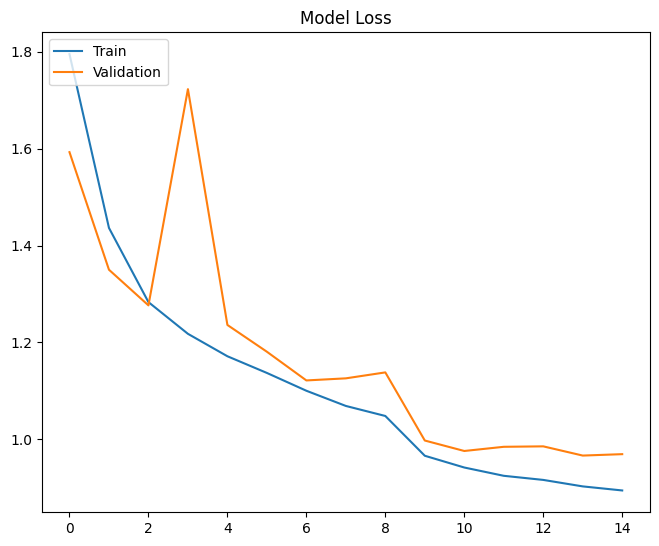

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

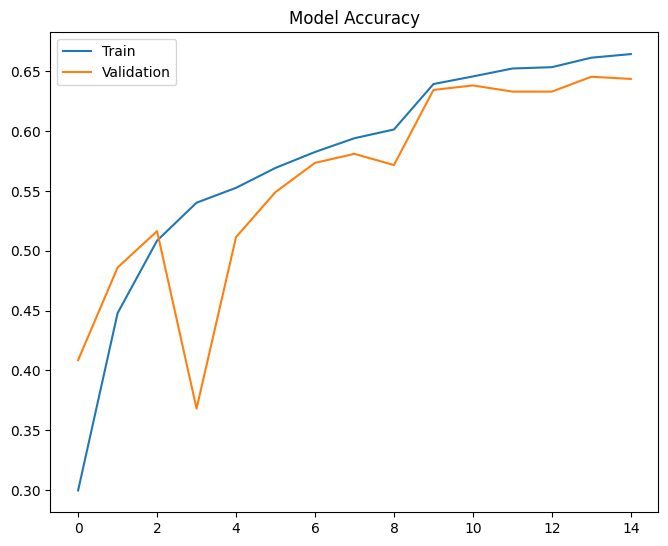

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [34]:
model_json=model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)